### __Predicting Airbnb Listing Prices in Sydney__

--- 
## Task 3: Fit and Tune Prediction Models/ Produce predictions


### Overview

#### Breakdown of the general procedure:

✅ **1. Load Data**
- Load cleaned dataset from `data/processed/processed_train.csv`
- Split into `train` and `test` sets

✅ **2. Train Multiple Models**
- Linear Regression (baseline)
- Decision Tree (simple tree-based model)
- Random Forest (strong tree ensemble model)
- Gradient Boosting, XGBoost, LightGBM (powerful boosting methods)
- Voting Regressor (combines multiple models for better results)

✅ **3. Cross-Validation**
- Evaluate a model on multiple subsets of data

✅ **4. Hyperparameter Tuning**
- Uses GridSearchCV to find the best RandomForestRegressor parameters

✅ **5. Compare Model Performance**
- Saves R² scores for each model
- Plots bar chart of model performance

✅ **6. Save the Best Model**
- Identifies the best-performing model
- Saves it as `results/best_model.pkl`

#### Models Selection Breakdown

Since we're predicting **Airbnb listing prices** (a continuous numerical target), this is a regression problem. Based on the nature of given datasets and typical challenges in price prediction, I selected a mix of traditional ML models and ensemble learning methods to balance interpretability, predictive power, and generalization.

To assist the hyperparameters tuning process, we utilize `K-fold Cross Validation` and `RandomizedSearchCV` method. Specifically, we select important parameters and set a suitable range for them so that the Random Search can identify the best performance with optimal parameters. For the _K-fold Cross Validation_ method, its purpose is to assess how well a ML model can generalize to unseen data by training and testing on different parts of the dataset multiple times and prevent overfitting.

#### Models Selection Strategy
1. Start with a simple model (`Linear Regression`) to establish a baseline
2. Use `Decision Trees` to see how non-linear relationships improve results
3. Apply `Ensemble Methods (Random Forest, Gradient Boosting)` to enhance predictive power
4. Use `Advanced Boosting Models (XGBoost, LightGBM)` for optimized performance
5. **Fine-tune hyperparameters** using `GridSearchCV` & `Bayesian Optimization`

### Import processed data

In [7]:
# Import libraries 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Models 
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
import xgboost as xgb
# import lightgbm as lgb

# Bayesian Optimization
from skopt import BayesSearchCV

In [8]:
# Set display options for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

# Configure seaborn aesthetics
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

In [24]:
# Retrieve the processed train dataset 
df = pd.read_csv(r"C:\Users\haiho\GITHUB\Sydney-Airbnb-prices-prediction\data\processed\processed_train.csv")

In [25]:
X = df.drop(['latitude', 'longitude', 'price'],axis=1) # Features
y = df['price'] # Target variable

In [26]:
X.head()

,ID,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,accommodates,bedrooms,beds,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,email,phone,reviews,jumio,Long term stays allowed,Wifi,Essentials,Smoke alarm,mapped_property_type,mapped_bathrooms,mapped_room_type,response_time
0,0,100.0,69.0,1,2.0,1,1,6,3,3,2,22,2,2,22,22,2,22,1,0,14,14,174,3,1,0,4.67,4.33,4.33,4.67,4.33,4.67,4.33,0,2,2,0,0,0.04,1,1,1,1,0,1,1,1,5,3.0,4,3
1,1,100.0,100.0,0,3.0,1,1,2,1,1,2,90,2,2,90,90,2,90,1,5,31,61,336,383,18,6,4.42,4.58,4.40,4.77,4.67,4.70,4.47,1,1,0,1,0,3.21,1,1,1,1,1,1,1,1,2,5.0,3,4
2,2,100.0,81.0,1,1.0,1,1,4,1,1,2,90,2,2,90,90,2,90,1,1,9,33,217,297,15,4,4.55,4.66,4.23,4.87,4.90,4.73,4.68,0,1,1,0,0,2.23,1,1,1,1,1,1,1,1,5,6.0,4,3
3,3,100.0,100.0,1,1.0,1,1,4,2,2,90,90,90,90,90,90,90,90,1,12,42,72,347,33,1,0,4.42,4.42,3.74,4.90,4.90,4.90,4.32,0,1,1,0,0,0.25,1,1,1,1,1,1,1,1,4,6.0,4,2
4,4,100.0,89.0,1,2.0,1,1,4,2,3,1,30,1,1,30,30,1,30,1,26,53,83,358,61,15,0,4.95,4.93,4.98,4.98,5.00,4.79,4.93,0,1,0,1,0,0.48,1,1,1,1,1,1,1,1,2,2.0,3,4


In [27]:
# Split into train & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
X_train.shape

(5600, 51)

In [38]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5600 entries, 1032 to 860
Data columns (total 51 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   ID                                            5600 non-null   int64  
 1   host_response_rate                            5600 non-null   float64
 2   host_acceptance_rate                          5600 non-null   float64
 3   host_is_superhost                             5600 non-null   int64  
 4   host_listings_count                           5600 non-null   float64
 5   host_has_profile_pic                          5600 non-null   int64  
 6   host_identity_verified                        5600 non-null   int64  
 7   accommodates                                  5600 non-null   int64  
 8   bedrooms                                      5600 non-null   int64  
 9   beds                                          5600 non-null   int6

In [21]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Save scaler
joblib.dump(scaler, "results/scaler.pkl")

### 1. Cross-Validation Function

To ensure our model generalizes well to unseen data, we use **K-Fold Cross-Validation (CV)**. This method splits the dataset into multiple folds, trains the model on some folds, and tests it on the remaining ones. 

- We define a **5-fold cross-validation strategy** using `KFold`, ensuring reproducibility with `random_state=42`.
- The `evaluate_model` function:
  - Computes **cross-validation scores** using the R² metric.
  - Prints the **mean R² score** and **standard deviation** to assess model stability.
  - Returns the mean R² score for further evaluation.

This approach helps us avoid overfitting and provides a robust estimate of model performance.


In [34]:
# Define cross-validation strategy (5-fold)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Helper function to evaluate models 
def evaluate_model(model, X, y):
    scores = cross_val_score(model, X, y, cv=cv, scoring="r2", n_jobs=-1)
    print(f"{model.__class__.__name__}: Mean R² = {scores.mean():.3f} | Std = {scores.std():.3f}")
    return scores.mean()

### 2. Baseline Model (Linear Regression)

Multiple linear regression (MLR) uses several explanatory variables to predict the outcome of a dependent variable. The goal of multiple linear regression is to model the linear relationship between the explanatory (independent) variables and response (dependent) variables.

In [ ]:
# Check for NaN values
print("NaN values in X_train:", np.isnan(X_train).sum().sum())
print("NaN values in y_train:", np.isnan(y_train).sum())
    
# Check for infinite values
print("Infinite values in X_train:", np.isinf(X_train).sum().sum())
print("Infinite values in y_train:", np.isinf(y_train).sum())


NaN values in X_train: 3
NaN values in y_train: 0
Infinite values in X_train: 0
Infinite values in y_train: 0


In [35]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

y_pred_lr = lin_reg.predict(X_test)
print(f"Linear Regression - R²: {r2_score(y_test, y_pred_lr):.3f}")

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

### 3. Train Multiple Models with Cross-Validation

In this step, we train multiple regression models and evaluate their performance using **5-fold cross-validation**. 

- We define a dictionary of models, including:
  - **Decision Tree**
  - **Random Forest**
  - **Gradient Boosting**
  - **XGBoost**
  - **LightGBM**

- Each model is trained and evaluated using the previously defined `evaluate_model` function.
- The results are stored in a **DataFrame** and sorted based on the **Mean R² score**, allowing us to compare model performance.

This process helps us determine which model generalizes best to our dataset before further fine-tuning.


In [ ]:
# Define multiple models with their parameters 
models = {
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    "XGBoost": xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    "LightGBM": lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
}

In [ ]:
# Store cross-validation results
cv_results = {name: evaluate_model(model, X_train, y_train) for name, model in models.items()}

In [ ]:
df_cv_results = pd.DataFrame(cv_results.items(), columns=["Model", "Mean R²"]).sort_values(by="Mean R²", ascending=False)

### 4. Hyperparameter Tuning with GridSearchCV

Selecting appropriate hyperparameter values for models like Random Forest, Gradient Boosting, XGBoost, and LightGBM is crucial for optimizing performance. Those ranges of values for each parameter of each model is carefully selected with a logic: 
- **Start with Defaults**: Begin with default settings to establish a baseline.
- **Incremental Testing**: Adjust one parameter at a time to observe its impact.
- **Cross-Validation**: Use techniques like GridSearchCV to systematically explore combinations.
- **Computational Resources**: Balance the depth and number of trees with available resources to manage training time.

In [ ]:
param_grids = {
    "Random Forest": {
        "n_estimators": [100, 300, 500],
        "max_depth": [10, 20, None],
        "min_samples_split": [2, 5, 10],
    },
    "Gradient Boosting": {
        "n_estimators": [100, 300, 500],
        "learning_rate": [0.01, 0.1, 0.2],
        "max_depth": [3, 5, 7],
    },
    "XGBoost": {
        "n_estimators": [100, 300, 500],
        "learning_rate": [0.01, 0.1, 0.2],
        "max_depth": [3, 6, 9],
    },
    "LightGBM": {
        "n_estimators": [100, 300, 500],
        "learning_rate": [0.01, 0.1, 0.2],
        "num_leaves": [20, 31, 40],
    },
}

In [ ]:
best_models = {}

for name, model in models.items():
    print(f"\n🔍 Tuning {name}...")
    grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring="r2", n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    best_models[name] = grid_search.best_estimator_
    print(f"✅ Best {name} Parameters: {grid_search.best_params_}")

### 5. Bayesian Optimization for Faster Tuning

In our Airbnb price prediction project, Bayesian Optimization serves as an advanced method for hyperparameter tuning. Unlike traditional approaches like grid or random search, Bayesian Optimization builds a probabilistic model of the objective function and uses this model to select the most promising hyperparameters to evaluate next.

In [ ]:
bayes_params = {
    "Random Forest": {
        "n_estimators": (100, 500),
        "max_depth": (5, 50),
        "min_samples_split": (2, 10),
    },
    "XGBoost": {
        "n_estimators": (100, 500),
        "learning_rate": (0.01, 0.3, "log-uniform"),
        "max_depth": (3, 9),
    },
}

In [ ]:
bayes_best_models = {}

for name in ["Random Forest", "XGBoost"]:
    print(f"\n🚀 Bayesian Optimization for {name}...")
    bayes_opt = BayesSearchCV(models[name], bayes_params[name], n_iter=20, cv=5, scoring="r2", n_jobs=-1, verbose=1)
    bayes_opt.fit(X_train, y_train)
    bayes_best_models[name] = bayes_opt.best_estimator_
    print(f"✅ Best {name} Parameters (Bayesian): {bayes_opt.best_params_}")

### 6. Model Comparison

In [ ]:
final_models = {**best_models, **bayes_best_models}

In [ ]:
results = {name: r2_score(y_test, model.predict(X_test)) for name, model in final_models.items()}
df_results = pd.DataFrame(results.items(), columns=["Model", "R² Score"]).sort_values(by="R² Score", ascending=False)

In [ ]:
plt.figure(figsize=(8, 5))
sns.barplot(data=df_results, x="Model", y="R² Score", palette="coolwarm")
plt.xticks(rotation=45)
plt.title("Final Model Performance Comparison")
plt.show()

### 7. Save the Best Model

In [ ]:
best_model_name = df_results.iloc[0]["Model"]
best_model = final_models[best_model_name]
joblib.dump(best_model, f"results/best_model.pkl")

In [ ]:
print(f"\n✅ Best model saved: {best_model_name}")

### Model 1. Multiple Linear Regression

`Overview:` 

Multiple linear regression (MLR) uses several explanatory variables to predict the outcome of a dependent variable. The goal of multiple linear regression is to model the linear relationship between the explanatory (independent) variables and response (dependent) variables.

In [ ]:
# Create MLR instance and fit the processed train data
lr = LinearRegression()

lr.fit(X, y)

y_lr = lr.predict(X)

# print(f'MSE after applying Multiple Linear Regression: {mean_squared_error(y, lr_y):.3f}')
# print(f'R^2 after applying Multiple Linear Regression: {r2_score(y, lr_y):.3f}')

LinearRegression()

MSE after applying Multiple Linear Regression: 57624.206
R^2 after applying Multiple Linear Regression: 0.498


In [ ]:
# Retrieve MSE and R-Squared results after applying the model
print(f'MSE after applying Multiple Linear Regression: {mean_squared_error(y, y_lr):.3f}')
print(f'R^2 after applying Multiple Linear Regression: {r2_score(y, y_lr):.3f}')

In [ ]:
# Define cross-validation method to use
cv_lr = KFold(n_splits=5, random_state=1, shuffle=True)

# Apply k-fold CV to evaluate model performance
scores_lr = cross_val_score(lr, X, y, scoring='neg_mean_squared_error', cv=cv_lr, n_jobs=-1)

In [ ]:
# Print the c-v score for multiple linear regression model
print(f'Cross validation score: {scores_lr.mean():.3f}')

Cross validation score: -65113.582


`Interpretation:`

The Mean Squared Error seems too high and the model only captures nearly 50% of the variance in the target variable `price`. This therefore indicates that the train dataset does not follow a linear relationship significantly. However, other nonlinear regression models' outcomes are carefully assessed to reinforce this conclusion.

2 lists including Mean Squared Error results and cross validation scores are built to compare the performance of all models.

In [ ]:
# List of MSE and cross validation scores of models
model_mse = []
model_mse.append(mean_squared_error(y, y_lr))

model_scores = []
model_scores.append(scores_lr.mean())

### Model 2. Random Forest Regressor

`Overview:` 

Random Forest is an ensemble technique capable of performing both regression and classification tasks with the use of multiple decision trees and a technique called Bootstrap Aggregation, commonly known as bagging. The basic idea behind this is to combine multiple decision trees in determining the final output rather than relying on individual decision trees.

`Default model:`

In [ ]:
# Create RF instance
forest = RandomForestRegressor()

forest.fit(X, y)

y_forest = forest.predict(X)

# print(f'MSE train after applying Random Forest Regression: {mean_squared_error(y, y_forest):.3f}')
# print(f'R^2 train after applying Random Forest Regression: {r2_score(y, y_forest):.3f}')

RandomForestRegressor()

MSE train after applying Random Forest Regression: 5577.452
R^2 train after applying Random Forest Regression: 0.951


In [ ]:
# Retrieve MSE and R-Squared results after applying the model
print(f'MSE train after applying Random Forest Regression: {mean_squared_error(y, y_forest):.3f}')
print(f'R^2 train after applying Random Forest Regression: {r2_score(y, y_forest):.3f}')

In [ ]:
# Use K-fold CV to evaluate model performance
fr_scores = cross_val_score(forest, X, y, cv=cv, n_jobs=-1)
print(f'Cross validation score: {fr_scores.mean():.3f}')

Cross validation score: 0.624


`Interpretation:`

The outputs of the **Random Forest Regression** model on train dataset is proved to be better than **Multiple Linear Regression** with a significantly lower MSE and a high R-squared value of 0.95 indicates that a larger proportion (95%) of the target features have been covered.

`Tuning model:`

Hyperparameters tuning technique allows us to tune the hyperparameters to have best performance of the algorithm. In this case, there are a total of 5 important parameters that we will set value ranges for: 
- n_estimators: number of trees in the forest
- max_depth: max number of levels in each decision tree 
- max_features: max number of features considered for splitting a node
- criterion: method to check
- bootstrap: method for sampling data points 

By using RandomizeSearchCV method, we can define a grid of hyperparameter ranges, and randomly from the grid, conducting K-Fold Cross Validation with each combination of values.

In [ ]:
# Number of trees in Random Forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 300, num = 50)]

# Maximum number of levels in tree
max_depth = [10,15]

# Number of features to consider at every split
max_features = [int(x) for x in np.linspace(10, 3, num = 3)]

# Criterion to split on
criterion = ['mse']

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the grid
grid = {'n_estimators': n_estimators,
        'max_depth': max_depth,
        'max_features': max_features,
        'criterion': criterion,            
        'bootstrap': bootstrap}

After fitting another Random Forest Regressor model and completing the random search, the optimal parameters for the model can be determined.

In [90]:
# Create the model to be tuned
fr_tune = RandomForestRegressor()

# Create the random search Random Forest
fr_grid = RandomizedSearchCV(estimator = fr_tune, param_distributions = grid, cv = 3, verbose = 2, random_state = 42, n_jobs = -1)

# Fit the random search model
fr_grid.fit(X, y)

# View the best parameters from the random search
fr_grid.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['mse'],
                                        'max_depth': [10, 15],
                                        'max_features': [10, 6, 3],
                                        'n_estimators': [50, 55, 60, 65, 70, 75,
                                                         80, 85, 90, 95, 101,
                                                         106, 111, 116, 121,
                                                         126, 131, 136, 141,
                                                         146, 152, 157, 162,
                                                         167, 172, 177, 182,
                                                         187, 192, 197, ...]},
                   random_state=42, verbose=2)

{'n_estimators': 146,
 'max_features': 10,
 'max_depth': 15,
 'criterion': 'mse',
 'bootstrap': False}

Now we re-fit the model with the best parameters achieved from the random search and generate the corresponding MSE and R-squared values. 

In [91]:
tune_forest = RandomForestRegressor(n_estimators = 146, criterion = 'mse', max_features = 10, max_depth= 15, bootstrap=False) 
tune_forest.fit(X, y)

RandomForestRegressor(bootstrap=False, max_depth=15, max_features=10,
                      n_estimators=146)

In [92]:
tune_forest_y = tune_forest.predict(X)

In [93]:
print(f'MSE train after tuning hyperparameters: {mean_squared_error(y, tune_forest_y):.3f}')
print(f'R^2 train after tunign hyperparameters: {r2_score(y, tune_forest_y):.3f}')

MSE train after tuning hyperparameters: 950.539
R^2 train after tunign hyperparameters: 0.992


It is evident the model's performance has been significantly improved since the Mean Squared Error drops to below 100 and a nearly perfect R-squared value of 0.992 is recorded. 

In [94]:
#use k-fold CV to evaluate model
tune_fr_scores = cross_val_score(tune_forest, X, y, cv=cv, n_jobs=-1)
print(f'Cross validation score: {tune_fr_scores.mean():.3f}')

Cross validation score: 0.663


In comparison with the default model, the cross validation score of the tuned Random Forest is slight higher which also indicates improvements in the model's performance.

In [96]:
#Append the outputs of the Random Forest models
model_mse.append(mean_squared_error(y, forest_y))
model_mse.append(mean_squared_error(y, tune_forest_y))
model_scores.append(fr_scores.mean())
model_scores.append(tune_fr_scores.mean())

### Model 3. Bagging Regressor

Overview: Bagging Regressor is an ensemble estimator which fits base estimator on each random subset of the training dataset and then aggregates their individual predictions to form a final prediction using voting or averaging method.

`Default model:`

In [97]:
#Create instance
bag = BaggingRegressor()

bag.fit(X, y)

bag_y = bag.predict(X)

print(f'MSE after applying Bagging Regressor: {mean_squared_error(y, bag_y):.3f}')
print(f'R^2 after applying Bagging Regressor: {r2_score(y, bag_y):.3f}')

BaggingRegressor()

MSE after applying Bagging Regressor: 8031.500
R^2 after applying Bagging Regressor: 0.930


In [98]:
#use k-fold CV to evaluate model
bag_scores = cross_val_score(bag, X, y, cv=cv, n_jobs=-1)
print(f'Cross validation score: {bag_scores.mean():.3f}')

Cross validation score: 0.603


*Interpretation:* 

The outputs of the default Bagging Regressor model seems to be not as good as those of Random Forest Regressor due to higher MSE and lower R-quared value (0.93). Therefore, we need to examine whether tuning hyperparameters can improve the model's performance or not.

`Tuning model:`

For the hyperparameters tuning process of the Bagging Regressor, we consider 4 main factors: 
- n_estimators: number of base estimators in the ensemble
- max_features: number of features to train each base estimator 
- bootstrap: method for sampling data points
- bootstrap_features: whether features are drawn with replacement or not.

By using RandomizeSearchCV method, we can define a grid of hyperparameter ranges, and randomly from the grid, conducting K-Fold Cross Validation with each combination of values.

In [99]:
bag_n_estimators = [int(x) for x in np.linspace(start = 50, stop = 300, num = 50)]

bag_max_features = [int(x) for x in np.linspace(10, 3, num = 3)]

bag_bootstrap = [True, False]
bag_bootstrap_features = [True, False]

# Create the grid
bag_grid = {'n_estimators': bag_n_estimators,
        'max_features': bag_max_features,
        'bootstrap': bag_bootstrap,
        'bootstrap_features': bag_bootstrap_features}

In [108]:
bag_tune = BaggingRegressor()
tune_bag = RandomizedSearchCV(bag_tune, param_distributions=bag_grid)
tune_bag.fit(X,y)

RandomizedSearchCV(estimator=BaggingRegressor(),
                   param_distributions={'bootstrap': [True, False],
                                        'bootstrap_features': [True, False],
                                        'max_features': [10, 6, 3],
                                        'n_estimators': [50, 55, 60, 65, 70, 75,
                                                         80, 85, 90, 95, 101,
                                                         106, 111, 116, 121,
                                                         126, 131, 136, 141,
                                                         146, 152, 157, 162,
                                                         167, 172, 177, 182,
                                                         187, 192, 197, ...]})

In [109]:
#View the best parameters from the random search
tune_bag.best_params_

{'n_estimators': 157,
 'max_features': 10,
 'bootstrap_features': False,
 'bootstrap': True}

In [110]:
tune_bag_y = tune_bag.predict(X)

In [111]:
print(f'MSE train after tuning hyperparameters: {mean_squared_error(y, tune_bag_y):.3f}')
print(f'R^2 train after tuning hyperparameters: {r2_score(y, tune_bag_y):.3f}')

MSE train after tuning hyperparameters: 8419.433
R^2 train after tuning hyperparameters: 0.927


In [113]:
#Use k-fold CV to evaluate model
tune_bag_scores = cross_val_score(tune_bag, X, y, cv=cv, n_jobs=-1)
print(f'Cross validation score: {tune_bag_scores.mean():.3f}')

Cross validation score: 0.590


*Interpretation:* 

The Bagging Regressor model after tuning hyperparameters clearly has a similar as the default model as there is not significant difference between their MSE or R-squared. Overall, not only for this model but also the Random Forest Regressor, changing parameters allows us to significantly improve the models' performances. Now we can compare all models to determine which one is the most desirable.

In [114]:
#Append the outputs of the Bagging models
model_mse.append(mean_squared_error(y, bag_y))
model_mse.append(mean_squared_error(y, tune_bag_y))
model_scores.append(bag_scores.mean())
model_scores.append(tune_bag_scores.mean())

### Models Comparison

We set up 2 new dataframes for all models' MSE and cross-validation scores.

In [121]:
models_mse = ["MLR", "RF", "Adjusted RF", "BR", "Adjusted BR" ]
df_mse = pd.DataFrame(models_mse, columns=["Model Type"])
df_mse["MSE"] = model_mse
df_mse

,Model Type,MSE
0,MLR,57624.205877
1,RF,5577.451734
2,Adjusted RF,950.538941
3,BR,8031.500430
4,Adjusted BR,8419.432886


In [118]:
models_crossvalscores = ["MLR", "RF", "Adjusted RF", "BR", "Adjusted BR" ]
df_scores = pd.DataFrame(models_crossvalscores, columns=["Model Type"])
df_scores["Cross-validation score"] = model_scores
df_scores

,Model Type,Cross-validation score
0,MLR,-65113.582334
1,RF,0.624418
2,Adjusted RF,0.663365
3,BR,0.602642
4,Adjusted BR,0.590407


Now we can visualize both datasets to have a better consideration.

<Figure size 720x288 with 0 Axes>

Text(0.5, 0, 'Models')

Text(0, 0.5, 'MSE')

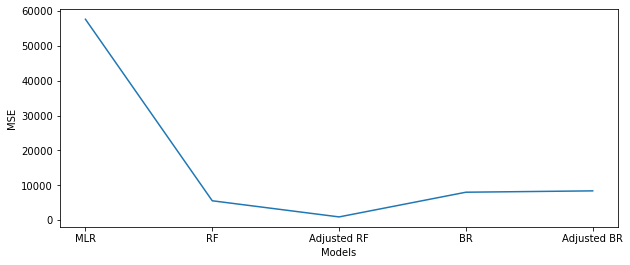

In [122]:
#Plotting the mse outputs
plt.figure(figsize = (10,4))
plt.plot(df_mse["Model Type"], df_mse["MSE"])
plt.xlabel("Models")
plt.ylabel("MSE")
plt.show()

<Figure size 720x288 with 0 Axes>

Text(0.5, 0, 'Models')

Text(0, 0.5, 'cross_val_score')

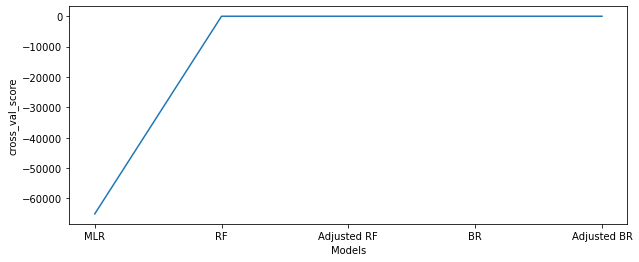

In [120]:
#Plotting the cross_val_scores outputs
plt.figure(figsize = (10,4))
plt.plot(df_scores["Model Type"], df_scores["Cross-validation score"])
plt.xlabel("Models")
plt.ylabel("cross_val_score")
plt.show()

All things considered, the Random Forest model with tuning hyperparameters has a considerably low MSE and a significant R-squared value which assist us to have more precise predictions based on the test dataset. Therefore, the Random Forest Regressor is the optimal model out of three.

### Predictions on test data

In [139]:
#Specify subset
test_input = df_test.drop(['ID','name','description','neighborhood_overview','host_name','host_since','host_location','host_about','host_neighbourhood','neighbourhood','neighbourhood_cleansed','first_review','last_review','license'],axis=1)
#Subset size
test_input.shape

(3000, 52)

In [140]:
#Predict the corresponding prices
submission = tune_forest.predict(test_input)
submission

array([ 49.81913358, 174.03116443, 179.30484841, ..., 245.28595734,
       219.37817902, 280.38274183])

In [132]:
#Set new column for price in the test set
df_test['price'] = submission

In [149]:
#Convert 2 columns of ID and price to a submission file
df_test[['ID','price']].to_csv('submission.csv',index=False)